In [1]:
# Cell 1 — install libs (run once)
!pip install -q pandas numpy matplotlib seaborn scipy statsmodels scikit-learn


In [2]:
# Cell 2 — Upload or auto-load dataset
from google.colab import files
import os
import pandas as pd
import seaborn as sns

# 1) Try to use an uploaded titanic.csv (use the "Choose Files" dialog)
print("If you have a local titanic.csv: upload it in the next prompt.")
uploaded = files.upload()  # click Choose Files -> select your titanic.csv
csv_name = None
for fn in uploaded.keys():
    if fn.lower().endswith('.csv'):
        csv_name = fn
        break

# 2) If not uploaded, check working dir for titanic.csv
if csv_name is None and os.path.exists('titanic.csv'):
    csv_name = 'titanic.csv'

# 3) Fallback: use seaborn sample dataset (demo only)
if csv_name is None:
    print("No titanic.csv uploaded/found — loading seaborn sample Titanic dataset as fallback.")
    df = sns.load_dataset('titanic')
    # seaborn dataset uses lowercase column names; normalize to the script's expected names
    if 'survived' in df.columns:
        df = df.rename(columns={'survived': 'Survived', 'pclass': 'Pclass', 'fare': 'Fare', 'age': 'Age', 'sex': 'Sex'})
else:
    print(f"Loading uploaded file: {csv_name}")
    df = pd.read_csv(csv_name)

print("Dataset loaded. Shape:", df.shape)
display(df.head())


If you have a local titanic.csv: upload it in the next prompt.


Saving Titanic-Dataset.csv to Titanic-Dataset.csv
Loading uploaded file: Titanic-Dataset.csv
Dataset loaded. Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Cell 3 — Run EDA and save outputs (plots + CSVs + inferences)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from IPython.display import Image, display

sns.set_style('whitegrid')
%matplotlib inline

plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

# Ensure we have df from previous cell
try:
    df
except NameError:
    raise RuntimeError("Dataframe `df` not found. Run the upload/load cell first.")

# normalize common column names if needed
if 'survived' in df.columns and 'Survived' not in df.columns:
    df = df.rename(columns={'survived': 'Survived'})
if 'pclass' in df.columns and 'Pclass' not in df.columns:
    df = df.rename(columns={'pclass': 'Pclass'})

# 1) Basic info
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

# 2) Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values (desc):")
print(missing[missing>0])

# 3) Numeric summary + skew/kurt
numeric = df.select_dtypes(include=[np.number]).copy()
summary = numeric.describe().T
summary['skew'] = numeric.skew()
summary['kurtosis'] = numeric.kurtosis()
print("\nNumeric summary (first 10 rows):")
display(summary.head(10))
summary.to_csv('summary_stats.csv')
print("Saved summary_stats.csv")

# 4) Histograms
for col in numeric.columns:
    plt.figure(figsize=(6,3.5))
    sns.histplot(numeric[col].dropna(), kde=True)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    fpath = os.path.join(plots_dir, f"hist_{col}.png")
    plt.savefig(fpath, dpi=150)
    plt.close()

# 5) Boxplots by Survived if present
if 'Survived' in df.columns:
    for col in numeric.columns:
        if col == 'Survived': continue
        plt.figure(figsize=(6,3.5))
        sns.boxplot(x=df['Survived'], y=df[col])
        plt.title(f"Boxplot {col} by Survived")
        plt.tight_layout()
        fpath = os.path.join(plots_dir, f"box_{col}_by_survived.png")
        plt.savefig(fpath, dpi=150)
        plt.close()

# 6) Correlation heatmap
if len(numeric.columns) > 1:
    corr = numeric.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Correlation matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "correlation_matrix.png"), dpi=150)
    plt.close()

# 7) Pairplot (sample to avoid slowness)
try:
    sample = numeric.sample(n=min(300, len(numeric)), random_state=42)
    sns.pairplot(sample)
    plt.suptitle("Pairplot (sample)", y=1.02)
    plt.savefig(os.path.join(plots_dir, "pairplot.png"), dpi=150)
    plt.close()
except Exception as e:
    print("Pairplot skipped:", e)

# 8) Skew detection and optional log transform demo
skew_series = numeric.skew().sort_values(ascending=False)
print("\nTop skewed numeric columns:")
print(skew_series.head(8))
skewed_cols = skew_series[abs(skew_series) > 1].index.tolist()
print("Columns with |skew| > 1:", skewed_cols)
for col in skewed_cols:
    if (numeric[col].dropna() > 0).all() and numeric[col].nunique() > 10:
        newc = f"{col}_log"
        df[newc] = np.log1p(df[col])
        plt.figure(figsize=(6,3.5))
        sns.histplot(df[newc].dropna(), kde=True)
        plt.title(f"{newc} (log1p)")
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f"hist_{newc}.png"), dpi=150)
        plt.close()

# 9) VIF calculation (numeric features only)
def calculate_vif(frame):
    X = frame.dropna(axis=0, how='any')  # drop rows with NA for VIF calc
    X = X.loc[:, X.nunique() > 1]        # drop constant cols
    vif_data = []
    if X.shape[1] < 2:
        return None
    for i, col in enumerate(X.columns):
        try:
            vif = variance_inflation_factor(X.values, i)
        except Exception:
            vif = np.nan
        vif_data.append((col, float(vif)))
    import pandas as pd
    return pd.DataFrame(vif_data, columns=['feature','VIF']).sort_values('VIF', ascending=False)

if not numeric.empty:
    vif_df = calculate_vif(numeric)
    if vif_df is not None:
        vif_df.to_csv('vif.csv', index=False)
        print("\nVIF top rows:")
        display(vif_df.head(10))
        print("Saved vif.csv")
    else:
        print("Not enough numeric columns for VIF.")

# 10) Simple imputation demo (median) and save
if not numeric.empty:
    imputer = SimpleImputer(strategy='median')
    imputed = imputer.fit_transform(numeric)
    import pandas as pd
    imputed_df = pd.DataFrame(imputed, columns=numeric.columns)
    imputed_df.to_csv('numeric_imputed_sample.csv', index=False)
    print("Saved numeric_imputed_sample.csv")

# 11) Categorical counts + countplots
categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:", categorical)
for col in categorical:
    counts = df[col].value_counts(dropna=False).head(10)
    print(f"\nTop counts for {col}:")
    print(counts)
    plt.figure(figsize=(6,3.5))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f"count_{col}.png"), dpi=150)
    plt.close()

# 12) Simple inferences saved to file
inferences = []
if 'Survived' in df.columns:
    if 'Sex' in df.columns:
        surv_by_sex = df.groupby('Sex')['Survived'].mean().sort_values(ascending=False)
        inferences.append(f"Survival higher for: {surv_by_sex.index[0]} (rate={surv_by_sex.iloc[0]:.2f})")
    if 'Pclass' in df.columns:
        surv_by_class = df.groupby('Pclass')['Survived'].mean().sort_values(ascending=False)
        inferences.append(f"Higher survival in Pclass: {surv_by_class.index[0]} (rate={surv_by_class.iloc[0]:.2f})")

with open('inferences.txt','w') as f:
    for line in inferences:
        f.write(line + '\n')

print("\nInferences saved to inferences.txt")
print("All plots saved into ./plots/")


Shape: (891, 12)

Columns and dtypes:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing values (desc):
Cabin       687
Age         177
Embarked      2
dtype: int64

Numeric summary (first 10 rows):


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000,0.000000,-1.200000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000,0.478523,-1.775005
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000,-0.630548,-1.280015
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000,0.389108,0.178274
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000,3.695352,17.880420
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000,2.749117,9.778125
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,4.787317,33.398141


Saved summary_stats.csv

Top skewed numeric columns:
Fare           4.787317
SibSp          3.695352
Parch          2.749117
Survived       0.478523
Age            0.389108
PassengerId    0.000000
Pclass        -0.630548
dtype: float64
Columns with |skew| > 1: ['Fare', 'SibSp', 'Parch']

VIF top rows:


,feature,VIF
2,Pclass,4.331430
3,Age,3.799999
0,PassengerId,3.705255
6,Fare,1.873504
1,Survived,1.712302
4,SibSp,1.622290
5,Parch,1.554214


Saved vif.csv
Saved numeric_imputed_sample.csv

Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Top counts for Name:
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
Allen, Mr. William Henry                               1
Moran, Mr. James                                       1
McCarthy, Mr. Timothy J                                1
Palsson, Master. Gosta Leonard                         1
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)      1
Name: count, dtype: int64

Top counts for Sex:
Sex
male      577
female    314
Name: count, dtype: int64

Top counts for Ticket:
Ticket
347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
382652          5
S.O.C. 14879    5
113760 

Files in working dir: ['vif.csv', 'Titanic-Dataset.csv', 'inferences.txt', 'numeric_imputed_sample.csv', 'summary_stats.csv']

Plots available (first 12):
['box_Age_by_survived.png', 'box_Fare_by_survived.png', 'box_Parch_by_survived.png', 'box_PassengerId_by_survived.png', 'box_Pclass_by_survived.png', 'box_SibSp_by_survived.png', 'correlation_matrix.png', 'count_Cabin.png', 'count_Embarked.png', 'count_Name.png', 'count_Sex.png', 'count_Ticket.png']


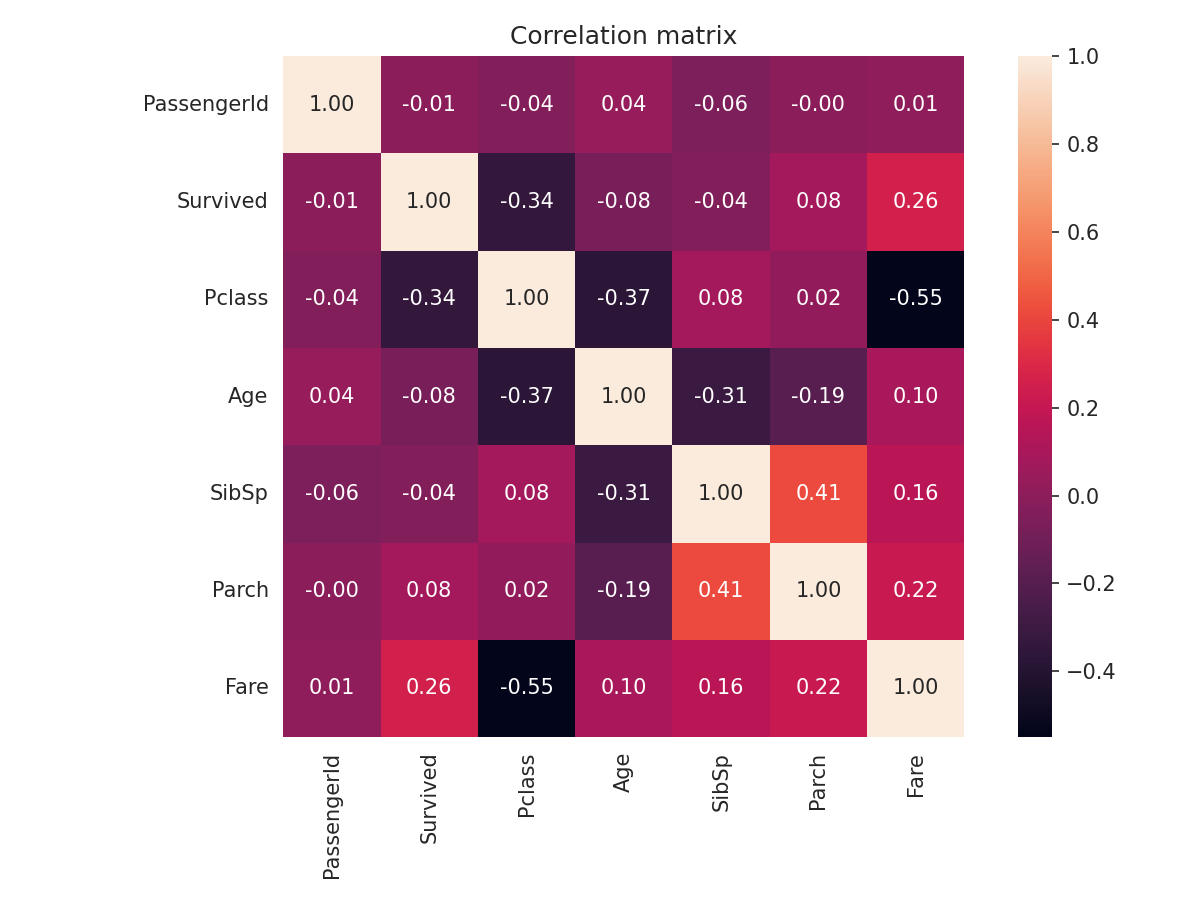

In [4]:
# Cell 4 — preview a few plots and list outputs
import os
from IPython.display import Image, display

print("Files in working dir:", [f for f in os.listdir('.') if f.endswith('.csv') or f.endswith('.txt')])
print("\nPlots available (first 12):")
plots = sorted(os.listdir('plots'))[:12]
print(plots)

# display the correlation matrix if present
if 'correlation_matrix.png' in plots:
    display(Image(os.path.join('plots','correlation_matrix.png')))
else:
    # display first plot
    if plots:
        display(Image(os.path.join('plots', plots[0])))


In [5]:
# Copy outputs to Drive (persistent)
from google.colab import drive
drive.mount('/content/drive')  # follow auth link

# choose a folder in your Drive, e.g. MyDrive/eda_outputs
dest = '/content/drive/MyDrive/eda_outputs'
os.makedirs(dest, exist_ok=True)

# copy files
import shutil
shutil.copy('summary_stats.csv', dest)
if os.path.exists('vif.csv'):
    shutil.copy('vif.csv', dest)
shutil.copy('numeric_imputed_sample.csv', dest)
shutil.copy('inferences.txt', dest)
shutil.make_archive('/content/eda_plots', 'zip', 'plots')
shutil.copy('/content/eda_plots.zip', dest)
print("Saved summary + zip to", dest)


Mounted at /content/drive
Saved summary + zip to /content/drive/MyDrive/eda_outputs


In [6]:
# Zip and download
!zip -r eda_outputs.zip plots summary_stats.csv numeric_imputed_sample.csv inferences.txt vif.csv
from google.colab import files
files.download('eda_outputs.zip')


  adding: plots/ (stored 0%)
  adding: plots/count_Name.png (deflated 15%)
  adding: plots/box_PassengerId_by_survived.png (deflated 19%)
  adding: plots/hist_PassengerId.png (deflated 14%)
  adding: plots/box_Age_by_survived.png (deflated 19%)
  adding: plots/box_Parch_by_survived.png (deflated 19%)
  adding: plots/correlation_matrix.png (deflated 10%)
  adding: plots/count_Sex.png (deflated 25%)
  adding: plots/box_Pclass_by_survived.png (deflated 21%)
  adding: plots/hist_Survived.png (deflated 14%)
  adding: plots/hist_Fare.png (deflated 17%)
  adding: plots/hist_Age.png (deflated 8%)
  adding: plots/count_Embarked.png (deflated 21%)
  adding: plots/hist_Pclass.png (deflated 14%)
  adding: plots/hist_Parch.png (deflated 13%)
  adding: plots/count_Ticket.png (deflated 18%)
  adding: plots/hist_SibSp.png (deflated 17%)
  adding: plots/pairplot.png (deflated 10%)
  adding: plots/count_Cabin.png (deflated 20%)
  adding: plots/box_SibSp_by_survived.png (deflated 19%)
  adding: plots/box

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>